In [1]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.stats import gaussian_kde

file_path = 'MPP_CellTracks_RawValues.xlsx'
df = pd.read_excel(file_path)
df.head(5)

# The first part of the code is on finding the ideal R threshold
# Once we have filtered the data we have to see how you actually 
# parametrize a distribution. 

,x-coordinate (um),y-coordinate (um),z-coordinate (um),Time increment (3-min interval)
0,10.5564,177.909,13.8359,0
1,10.0210,175.347,15.0267,1
2,9.8610,173.524,16.4436,2
3,9.5210,169.617,17.6764,3
4,9.0260,170.557,17.0045,4


In [2]:
#Function to calculate step lengths
# First cell traj goes up to 174 time increments  
df = pd.read_excel(file_path)
def calc_step_length(df):
    df['group_id'] = (df['Time increment (3-min interval)'] == 0).cumsum()  # Create a unique identifier for each trajectory

    df['dx'] = df.groupby('group_id')['x-coordinate (um)'].diff()
    df['dy'] = df.groupby('group_id')['y-coordinate (um)'].diff()
    df['dz'] = df.groupby('group_id')['z-coordinate (um)'].diff()
    
    df['step_length'] = np.sqrt(df['dx']**2 + df['dy']**2 + df['dz']**2)
    df = df[df['step_length'] >= 7.2]
    df = df.dropna(subset=['step_length'])
    
    group_means = df.groupby('group_id')['step_length'].mean()
    df['normalized_step_length'] = df.apply(lambda row: row['step_length'] / group_means[row['group_id']], axis=1)
    group_mean_dict = group_means.to_dict()
    normalized_step_length = df['normalized_step_length'].to_numpy()
    
    return df, normalized_step_length, group_mean_dict

df, normalized_steps, mean_steps = calc_step_length(df)

In [3]:
df

,x-coordinate (um),y-coordinate (um),z-coordinate (um),Time increment (3-min interval),group_id,dx,dy,dz,step_length,normalized_step_length
128,12.7331,191.347,17.49040,128,1,-0.1496,-9.410,-0.32110,9.416665,1.132507
130,15.8534,183.130,17.97730,130,1,3.4259,-6.334,0.34520,7.209404,0.867048
140,16.3015,180.479,18.35660,140,1,-0.7740,8.084,-0.06280,8.121211,0.976708
141,16.3813,188.562,18.49750,141,1,0.0798,8.083,0.14090,8.084622,0.972307
157,12.1436,201.034,20.76940,157,1,-1.3209,8.393,2.06020,8.742520,1.051430
...,...,...,...,...,...,...,...,...,...,...
8120,105.0590,191.198,7.50000,27,115,-5.6860,5.957,0.00000,8.235074,0.739228
8128,112.6490,206.250,3.84055,35,115,0.9340,2.200,-8.64615,8.970411,0.805236
8133,116.2170,208.450,22.12890,40,115,0.8270,2.200,10.71930,10.973938,0.985084
8138,120.3330,206.250,20.62570,45,115,1.1840,-5.500,-10.10930,11.569348,1.038532


In [4]:
def R_filter(steps, R = 0.72):
    filtered_steps = steps[steps >= R]
    return filtered_steps


# take mean for traj and divide all vals in that traj by it and create
# a dimensionless array to put into the distribution.

In [23]:
def sample_kde(in_x, n_samples, return_kde=False, lower=None):
    kde = gaussian_kde(in_x)
    if lower is not None:
        out = np.zeros(n_samples,)
        n = 0
        while n < n_samples:
            proposal = kde.resample(1)[0][0]
            if proposal < lower:
                continue
            out[n] = proposal
            n += 1
        if return_kde:
            return out, kde
        return kde
    else:
        if return_kde:
            return kde.resample(n_samples)[0], kde
        return kde.resample(n_samples)[0]

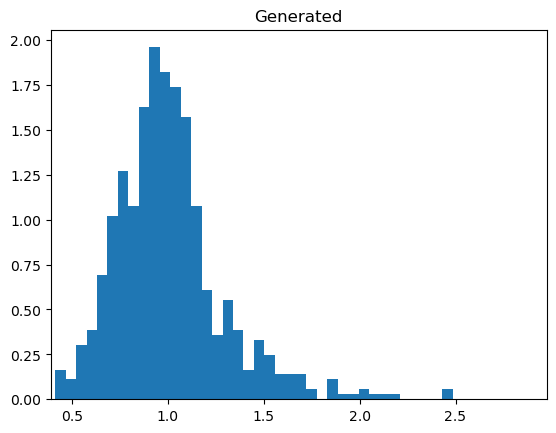

(0.3894366389423615, 2.9753743108278856)

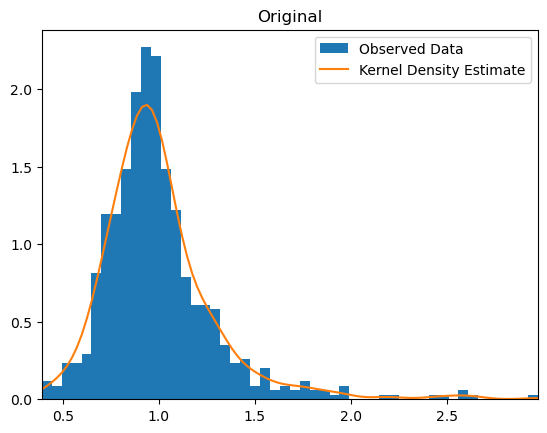

In [58]:
# Plotting and testing functions
## steps is ss with all sampled steps 
samples, kde = sample_kde(normalized_steps, len(normalized_steps), return_kde=True)
plt.hist(samples, density=True, bins=50)
plt.title('Generated')
plt.xlim(normalized_steps.min(), normalized_steps.max())
plt.show()
plt.hist(normalized_steps, density=True, bins=50, label='Observed Data')
plt.title('Original')
xx = np.linspace(normalized_steps.min(), normalized_steps.max(), 100)
plt.plot(xx, kde.evaluate(xx), label='Kernel Density Estimate')
plt.legend()
plt.xlim(normalized_steps.min(), normalized_steps.max())

In [35]:
#Time distributions
def calc_time(dt, R=7.2):
    #dt['Time increment (3-min interval)'] = dt['Time increment (3-min interval)'].fillna(0)
    #dt['group_id'] = (dt['Time increment (3-min interval)'] == 0).cumsum()  # Create a unique identifier for each trajectory
    
    #dt = dt.dropna(subset=['step_length'])
    #dt = dt[dt['step_length'] >= R]
    dt['time_diff'] = dt.groupby('group_id')['Time increment (3-min interval)'].diff()
    
    dt = dt.dropna(subset=['time_diff'])
    
    
    group_means = dt.groupby('group_id')['time_diff'].mean()
    dt['normalized_time'] = dt.apply(lambda row: row['time_diff'] / group_means[row['group_id']], axis=1)
    group_mean_dict = group_means.to_dict()
    normalized_times = dt['normalized_time'].to_numpy()
    
    return dt, normalized_times, group_mean_dict


/var/folders/5w/9zt5t7_14tvdtftx3r3fgm880000gn/T/ipykernel_18617/2276539437.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt['normalized_time'] = dt.apply(lambda row: row['time_diff'] / group_means[row['group_id']], axis=1)


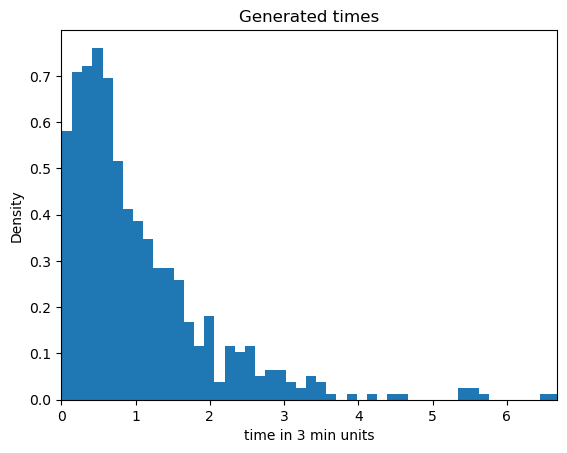

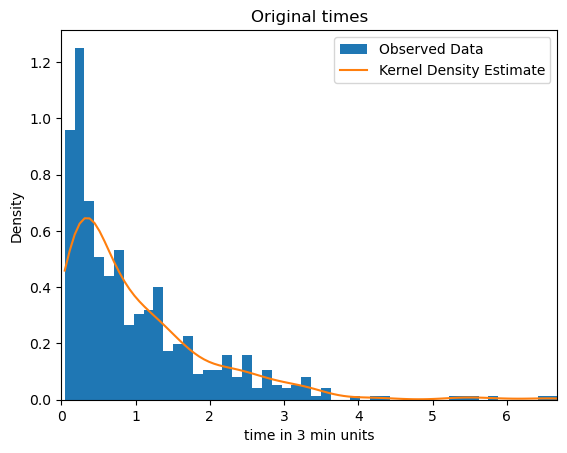

,x-coordinate (um),y-coordinate (um),z-coordinate (um),Time increment (3-min interval),group_id,dx,dy,dz,step_length,normalized_step_length,time_diff,norm,numerator,angle,normalized_time
130,15.8534,183.130,17.97730,130,1,3.4259,-6.334,0.34520,7.209404,0.867048,2.0,7.209404,58.979582,0.518082,0.275862
140,16.3015,180.479,18.35660,140,1,-0.7740,8.084,-0.06280,8.121211,0.976708,10.0,8.121211,-53.877381,2.739409,1.379310
141,16.3813,188.562,18.49750,141,1,0.0798,8.083,0.14090,8.084622,0.972307,1.0,8.084622,65.272358,0.108286,0.137931
157,12.1436,201.034,20.76940,157,1,-1.3209,8.393,2.06020,8.742520,1.051430,16.0,8.742520,68.025493,0.274932,2.206897
266,188.4290,202.858,12.50000,3,3,1.2980,-8.252,0.00000,8.353461,0.870891,2.0,8.353461,57.486870,0.685596,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8120,105.0590,191.198,7.50000,27,115,-5.6860,5.957,0.00000,8.235074,0.739228,3.0,8.235074,47.406474,0.675969,0.625000
8128,112.6490,206.250,3.84055,35,115,0.9340,2.200,-8.64615,8.970411,0.805236,8.0,8.970411,7.794676,1.465084,1.666667
8133,116.2170,208.450,22.12890,40,115,0.8270,2.200,10.71930,10.973938,0.985084,5.0,10.973938,-87.068258,2.656162,1.041667
8138,120.3330,206.250,20.62570,45,115,1.1840,-5.500,-10.10930,11.569348,1.038532,5.0,11.569348,-119.485451,2.796716,1.041667


In [59]:
## sampled_times is array with sampled_times

dt, filtered_times, mean_times = calc_time(df, R=7.2)
sample_data, kde = sample_kde(filtered_times, len(filtered_times), return_kde=True, lower=0)
plt.hist(sample_data, density=True, bins=50)
plt.title('Generated times')
plt.xlabel('time in 3 min units')
plt.ylabel('Density')
plt.xlim(0, filtered_times.max())
plt.show()
plt.hist(filtered_times, density=True, bins=50, label='Observed Data')
plt.title('Original times')
plt.xlabel('time in 3 min units')
plt.ylabel('Density')
xx = np.linspace(filtered_times.min(), filtered_times.max(), 100)
plt.plot(xx, kde.evaluate(xx), label='Kernel Density Estimate')
plt.legend()
plt.xlim(0, filtered_times.max())
plt.show()
#print(filtered_times.min(), filtered_times.max(), np.median(filtered_times))
#print(sampled_times.min(), sampled_times.max(), np.median(sampled_times))
dt

In [42]:
#df -> dt
#.  |_> da
def calc_angles(da, R=7.2):
    
    #da = da.dropna(subset=['step_length'])
    #da = da[da['step_length'] >= R]
    da['norm'] = np.sqrt(da['dx'] ** 2 + da['dy'] ** 2 + da['dz'] ** 2)

    da['prev_dx'] = da.groupby('group_id')['dx'].shift(1)
    da['prev_dy'] = da.groupby('group_id')['dy'].shift(1)
    da['prev_dz'] = da.groupby('group_id')['dz'].shift(1)
    da['prev_norm'] = da.groupby('group_id')['norm'].shift(1)

    da['numerator'] = (da['dx'] * da['prev_dx'] + da['dy'] * da['prev_dy'] + da['dz'] * da['prev_dz'])
    da['angle'] = np.arccos(da['numerator'] / (da['norm'] * da['prev_norm']))

    da.drop(['prev_dx', 'prev_dy', 'prev_dz', 'prev_norm'], axis=1, inplace=True)
    da = da.dropna(subset=['angle'])
    #angles = angles[~np.isnan(angles)]

    def circular_mean(angles):
        sin_mean = np.mean(np.sin(angles))
        cos_mean = np.mean(np.cos(angles))
        return np.arctan2(sin_mean, cos_mean)

    group_means = da.groupby('group_id')['angle'].agg(circular_mean)
    da['normalized_angles'] = da.apply(lambda row: (row['angle'] / group_means[row['group_id']]) % np.pi, axis=1)
    group_mean_dict = group_means.to_dict()
    normalized_angles = da['normalized_angles'].to_numpy()

    
    return da, normalized_angles, group_mean_dict



In [43]:
def sample_angles(in_angles, n_samples, bins=1000):
    out = np.zeros(n_samples)
    # removed , range=(0.72, in_times.max() since its for steps
    probs, vals = np.histogram(in_angles, bins=bins)
    probs = probs / np.sum(probs)
    for n in range(n_samples):
        bin_idx = np.nonzero(np.random.multinomial(1, probs))[0]
        low = vals[bin_idx - 1]
        high = vals[bin_idx]
        out[n] = np.random.uniform(low, high)
    return out

566 0.02212881231318248 2.8664558458353615 1.0067795396459882 0.9801930529403782


/var/folders/5w/9zt5t7_14tvdtftx3r3fgm880000gn/T/ipykernel_18617/657421759.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da['normalized_angles'] = da.apply(lambda row: (row['angle'] / group_means[row['group_id']]) % np.pi, axis=1)


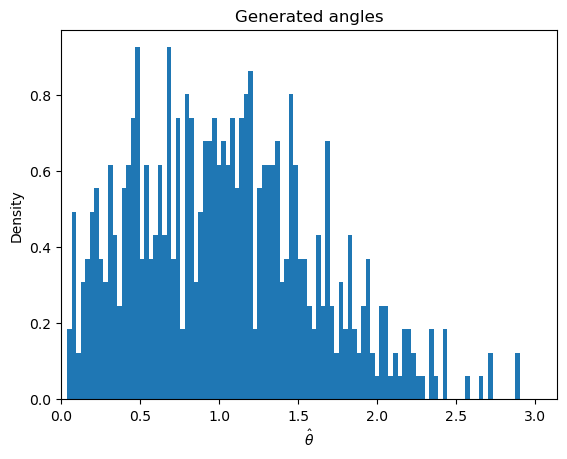

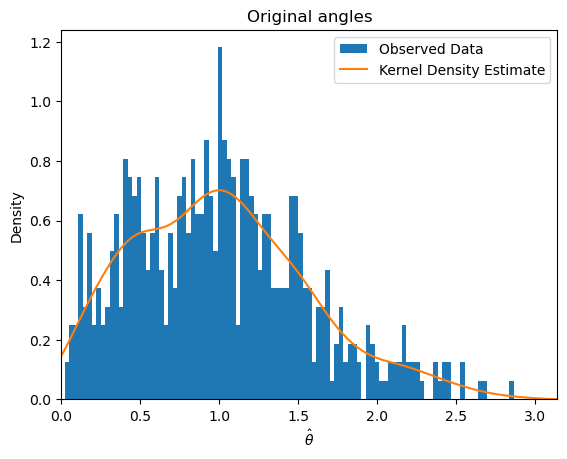

In [57]:
## sampled****_angles is array with all angles 
da, angles, mean_angles = calc_angles(df)
print(len(angles),angles.min(), angles.max(), angles.mean(), np.median(angles))
samples, kde = sample_kde(angles, len(angles), return_kde=True, lower=0)
plt.hist(samples, density=True, bins=100)
plt.title('Generated angles')
plt.xlabel(r"$\hat{\theta}$")
plt.ylabel('Density')
plt.xlim(0, np.pi)
plt.show()
plt.hist(angles, density=True, bins=100, label='Observed Data')
plt.title('Original angles')
plt.xlabel(r"$\hat{\theta}$")
plt.ylabel('Density')
xx = np.linspace(0, np.pi, 100)
plt.plot(xx, kde.evaluate(xx), label='Kernel Density Estimate')
plt.legend()
plt.xlim(0, np.pi)
plt.show()
sampled_angles = sample_angles(angles, len(angles), bins=100)


In [13]:
from scipy.stats import gaussian_kde


In [14]:
#R opti
def calculate_tamsd(step_lengths, max_lag=None):
    N = len(step_lengths)
    if max_lag is None:
        max_lag = N // 4  # Limit the maximum lag to a quarter of the total length

    tamsd = np.zeros(max_lag)
    for tau in range(1, max_lag + 1):
        sum_sq_displacements = 0
        count = 0
        for start in range(N - tau):  # Ensure not to exceed bounds
            sum_sq_displacements += (step_lengths[start + tau] - step_lengths[start]) ** 2
            count += 1
        tamsd[tau - 1] = sum_sq_displacements / count

    return tamsd


# RSSE test to optimize for R
def sse_function(R, experimental_data, experimental_tamsd):
    filt_experimental_data = R_filter(experimental_data, R)
    
    simulated_data = sample_from_steps(experimental_data, len(experimental_data))  # Assuming function to generate simulated data
    filt_simulated_data = R_filter(simulated_data, R)

    filt_experimental_tamsd = calculate_tamsd(filt_experimental_data)
    filt_simulated_tamsd = calculate_tamsd(filt_simulated_data)

    min_len = min(len(filt_experimental_tamsd), len(filt_simulated_tamsd))
    sse = np.sum((filt_experimental_tamsd[:min_len] - filt_simulated_tamsd[:min_len]) ** 2)
    return sse

def optimize_threshold(data, experimental_tamsd):
    experimental_tamsd = calculate_tamsd(experimental_data)
    result = minimize(sse_function, x0=[4], args=(data, experimental_tamsd), bounds=[(0, None)])
    if result.success:
        return result.x[0]
    else:
        raise RuntimeError("Optimization did not converge")


# are some of these pointless if i calculate them in the sse funct
experimental_data = steps[:172]  
experimental_tamsd = calculate_tamsd(experimental_data) 
optimal_R = optimize_threshold(experimental_data, experimental_tamsd)
print("Optimal R:", optimal_R)
time_lags = np.arange(1, len(experimental_tamsd) + 1)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(time_lags, R_filter(experimental_tamsd, 0.72), marker='o', linestyle='-', color='b')
plt.title('Time-Averaged Mean Squared Displacement (TAMSD)')
plt.xlabel('Time Lag')
plt.ylabel('TAMSD')
plt.grid(True)
plt.show()

NameError: name 'steps' is not defined

In [ ]:
# This graph shows the steps size per trajectory 
# might use it to remove outliers 
# need to revert this back to old version on github since 
# the new calc_step_lenght is not compatible with the normalized traj it returns

dfx = pd.read_excel(file_path)
dfx, m, n = calc_step_length(dfx)


for name, group in dfx.groupby('group_id'):
    plt.plot(group['Time increment (3-min interval)'], group['step_length'], label=f'Trajectory {name}')
    
plt.xlabel('Time increment (3-min interval)')
plt.ylabel('Step Length (um)')
plt.title('Step Lengths Over Time for Multiple Trajectories')
plt.legend()
plt.show()
dfx

In [ ]:
## Anotated version

for name, group in df.groupby('group_id'):
    plt.plot(group['Time increment (3-min interval)'], group['step_length'], label=f'Trajectory {name}')
    max_idx = group['step_length'].idxmax()
    plt.annotate(f'Traj {name}', 
                 (group.loc[max_idx, 'Time increment (3-min interval)'], group.loc[max_idx, 'step_length']),
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.xlabel('Time increment (3-min interval)')
plt.ylabel('Step Length (um)')
plt.title('Step Lengths Over Time for Multiple Trajectories')
plt.legend()
plt.show()

In [ ]:
da